## Compressing Data to the IoT Gateway using Autoencoders

Dataset: http://db.csail.mit.edu/labdata/labdata.html

The goal of this project is to reduce the amount of data sent to the gateway layer from edge devices. We use a dataset collected from Intel Labs, and attempt to reduce the size of the data into a form that is a representation of the original data. By reducing the amount of data sent from the sensor to the gateway, we can increase data throughput and decrease network latency.

### Data Loading

In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with gzip.open('data.txt.gz', 'rb') as data_bytes:
    data = pd.read_csv(data_bytes, header=None, sep=' ', parse_dates=[[0, 1]], squeeze=True)
data.columns = ['DATETIME','EPOCH','MOTE_ID','TEMPERATURE','HUMIDITY','LIGHT','VOLTAGE']
data = data.set_index('DATETIME')
data.shape

(2313682, 6)

### Data Pre-processing

We will consider sensor data between March 1st and March 10th, resampled every 5 minutes. We will ignore the epoch column, as it does not provide any statistical relevance.

In [3]:
data_samp = data.drop('EPOCH', axis=1)
data_samp = data_samp.loc['2004-03-01':'2004-03-10']
data_samp.head()

,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
DATETIME,,,,,
2004-03-01 00:01:57.130850,1.0,18.4498,43.1191,43.24,2.67532
2004-03-01 00:02:50.458234,1.0,18.4400,43.0858,43.24,2.66332
2004-03-01 00:04:26.606602,1.0,18.4400,43.1191,43.24,2.65143
2004-03-01 00:05:28.379208,1.0,18.4498,43.0524,43.24,2.65143
2004-03-01 00:05:50.456126,1.0,18.4302,43.1525,43.24,2.66332


For the sake of out experiment, let us only consider sensors 1-10. We will drop sensors where Sensor_ID is NA, and make Sensor_ID an integer.

In [4]:
data_samp.dropna(subset=['MOTE_ID'], inplace=True)
data_samp.MOTE_ID = data_samp.MOTE_ID.astype(int)

data_samp = data_samp[(data_samp.MOTE_ID >= 1) & (data_samp.MOTE_ID <= 10)].copy()
print('Sensor_ID - Min: {}, Max: {}'.format(data_samp.MOTE_ID.min(), data_samp.MOTE_ID.max()))
data_samp.shape

Sensor_ID - Min: 1, Max: 10


(154618, 5)

Constructing a dataframe where Sensor_ID is the key. This will be more representative of inbound samples.

In [5]:
sensor_df = data_samp.set_index('MOTE_ID', append=True).unstack()

Resampling the dataframe every minute, excluding the Sensor_ID index.

In [6]:
sensor_df

TEMPERATURE                                     \
MOTE_ID                             1        2        3        4   5   6    
DATETIME                                                                    
2004-03-01 00:00:21.445722         NaN      NaN      NaN      NaN NaN NaN   
2004-03-01 00:00:22.429139         NaN  18.8712      NaN      NaN NaN NaN   
2004-03-01 00:00:25.633782         NaN      NaN      NaN      NaN NaN NaN   
2004-03-01 00:00:52.381230         NaN  18.8614      NaN      NaN NaN NaN   
2004-03-01 00:00:53.317719         NaN      NaN      NaN      NaN NaN NaN   
...                                ...      ...      ...      ...  ..  ..   
2004-03-10 09:06:02.532096         NaN      NaN      NaN      NaN NaN NaN   
2004-03-10 09:06:02.659997         NaN      NaN  23.6536      NaN NaN NaN   
2004-03-10 09:06:07.690233         NaN      NaN      NaN      NaN NaN NaN   
2004-03-10 09:06:08.303196         NaN  23.1636      NaN      NaN NaN NaN   
2004-03-10 09:06:09.297230         NaN      NaN      NaN  23.8692 NaN NaN   

                                                          ... VOLTAGE  \
MOTE_ID                          7        8       9   10  ...      1    
DATETIME                                                  ...           
2004-03-01 00:00:21.445722      NaN      NaN  18.489 NaN  ...     NaN   
2004-03-01 00:00:22.429139      NaN      NaN     NaN NaN  ...     NaN   
2004-03-01 00:00:25.633782  18.7144      NaN     NaN NaN  ...     NaN   
2004-03-01 00:00:52.381230      NaN      NaN     NaN NaN  ...     NaN   
2004-03-01 00:00:53.317719  18.7046      NaN     NaN NaN  ...     NaN   
...                             ...      ...     ...  ..  ...     ...   
2004-03-10 09:06:02.532096      NaN  25.5058     NaN NaN  ...     NaN   
2004-03-10 09:06:02.659997      NaN      NaN     NaN NaN  ...     NaN   
2004-03-10 09:06:07.690233  23.9280      NaN     NaN NaN  ...     NaN   
2004-03-10 09:06:08.303196      NaN      NaN     NaN NaN  ...     NaN   
2004-03-10 09:06:09.297230      NaN      NaN     NaN NaN  ...     NaN   

                                                                        \
MOTE_ID                          2        3        4   5   6        7    
DATETIME                                                                 
2004-03-01 00:00:21.445722      NaN      NaN      NaN NaN NaN      NaN   
2004-03-01 00:00:22.429139  2.63964      NaN      NaN NaN NaN      NaN   
2004-03-01 00:00:25.633782      NaN      NaN      NaN NaN NaN  2.65143   
2004-03-01 00:00:52.381230  2.65143      NaN      NaN NaN NaN      NaN   
2004-03-01 00:00:53.317719      NaN      NaN      NaN NaN NaN  2.65143   
...                             ...      ...      ...  ..  ..      ...   
2004-03-10 09:06:02.532096      NaN      NaN      NaN NaN NaN      NaN   
2004-03-10 09:06:02.659997      NaN  2.60491      NaN NaN NaN      NaN   
2004-03-10 09:06:07.690233      NaN      NaN      NaN NaN NaN  2.60491   
2004-03-10 09:06:08.303196  2.58226      NaN      NaN NaN NaN      NaN   
2004-03-10 09:06:09.297230      NaN      NaN  2.58226 NaN NaN      NaN   

                                                  
MOTE_ID                          8        9   10  
DATETIME                                          
2004-03-01 00:00:21.445722      NaN  2.73696 NaN  
2004-03-01 00:00:22.429139      NaN      NaN NaN  
2004-03-01 00:00:25.633782      NaN      NaN NaN  
2004-03-01 00:00:52.381230      NaN      NaN NaN  
2004-03-01 00:00:53.317719      NaN      NaN NaN  
...                             ...      ...  ..  
2004-03-10 09:06:02.532096  2.62796      NaN NaN  
2004-03-10 09:06:02.659997      NaN      NaN NaN  
2004-03-10 09:06:07.690233      NaN      NaN NaN  
2004-03-10 09:06:08.303196      NaN      NaN NaN  
2004-03-10 09:06:09.297230      NaN      NaN NaN  

[154618 rows x 40 columns]

In [7]:
sensor_df = sensor_df.resample('5min').mean()

Checking for empty data values...

In [8]:
sensor_df.isna().sum()

             MOTE_ID
TEMPERATURE  1             0
             2            24
             3             0
             4             5
             5          2702
             6            16
             7             0
             8            20
             9             1
             10            2
HUMIDITY     1             0
             2            24
             3             0
             4             5
             5          2702
             6            16
             7             0
             8            20
             9             1
             10            2
LIGHT        1             0
             2            24
             3             0
             4             5
             5          2702
             6            16
             7             0
             8           174
             9           201
             10            2
VOLTAGE      1             0
             2            24
             3             0
             4        

Dropping Sensor_ID 5 since it appears to be missing every value.

In [9]:
sensor_df = sensor_df.stack().drop(5, level='MOTE_ID')

Looking at missing data values, we can apply linear interpolation to fill in the missing values to complete our data set.

In [10]:
sensor_df = sensor_df.interpolate(method='linear', limit_direction='both', axis=0)

In [11]:
sensor_df.describe()

,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
count,24250.000000,24250.000000,24250.000000,24250.000000
mean,21.934324,37.972666,308.209249,2.636275
std,2.112951,15.299638,461.575936,0.045781
min,15.708250,-2214.270975,0.411123,1.970964
25%,20.518927,34.739031,49.220000,2.602636
50%,21.876942,38.665795,114.080000,2.631853
75%,23.308518,41.818667,353.280000,2.663357
max,28.641800,49.542530,1847.360000,2.809478


Reassign our transposed matrix to the original matrix.

In [12]:
sensor_df

TEMPERATURE   HUMIDITY    LIGHT   VOLTAGE
DATETIME            MOTE_ID                                           
2004-03-01 00:00:00 1          18.443267  43.108000    43.24  2.663357
                    2          18.850375  43.469025   128.80  2.644061
                    3          18.751640  42.698420    48.76  2.653808
                    4          19.109200  42.513057    97.52  2.618043
                    6          18.669075  42.684987   114.08  2.609215
...                                  ...        ...      ...       ...
2004-03-10 09:05:00 6          24.138700  29.898100  1199.68  2.571080
                    7          23.937800  30.040100   235.52  2.604910
                    8          25.515600  27.075800  1729.60  2.627960
                    9          26.250600  27.039800  1847.36  2.687420
                    10         24.707100  29.827100   507.84  2.604910

[24250 rows x 4 columns]

In [13]:
sensor_df = sensor_df.reset_index(level=1)

In [16]:
sensor_df.head()

,MOTE_ID,TEMPERATURE,HUMIDITY,LIGHT,VOLTAGE
DATETIME,,,,,
2004-03-01,1,18.443267,43.108000,43.24,2.663357
2004-03-01,2,18.850375,43.469025,128.80,2.644061
2004-03-01,3,18.751640,42.698420,48.76,2.653808
2004-03-01,4,19.109200,42.513057,97.52,2.618043
2004-03-01,6,18.669075,42.684987,114.08,2.609215


As a sample, let us show timeseries plots for Temperature, Humidity, Light, and Voltage:

AttributeError: 'Line2D' object has no property 'xlabel'

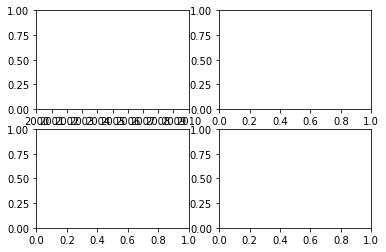

In [35]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sensor_df.TEMPERATURE, color='blue', xlabel='Temperature', ylabel='DATETIME')
axs[0, 0].set_title('Axis [0,0]')
axs[0, 1].plot(sensor_df.HUMIDITY, color='blue', xlabel='Temperature', ylabel='DATETIME')
axs[0, 1].set_title('Axis [0,1]')
axs[1, 0].plot(sensor_df.LIGHT, color='blue', )
axs[1, 0].set_title('Axis [1,0]')
axs[1, 1].plot(sensor_df.VOLTAGE, color='blue')
axs[1, 1].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
#input_layer = Input(shape=(4,))
# "encoded" is the encoded representation of the input
#encoded = Dense(1, activation='relu')(input_layer)
# "decoded" is the lossy reconstruction of the input
#decoded = Dense(4, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
#autoencoder = Model(input_layer, decoded)

In [ ]:
# autoencoder.summary()